In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
all_dfs = []
for i in [4,8,9]:
    print(i)
    df = pd.read_csv('data/'+str(i)+'_mw_disp_full.csv')
    df.columns = ['x', 'y', 'z']
    df['t_ns'] = np.arange(df.shape[0])*0.1/1000
    df = df.iloc[::1000, :] # keep only every 100 ps
    df['traj'] = i
    all_dfs.append(df)
df = pd.concat(all_dfs)

4
8
9


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [4]:
df.head()

,x,y,z,t_ns,traj
0,-0.05445,-0.01683,0.01155,0.0,4
1000,-0.09887,-0.05656,0.02406,0.1,4
2000,-0.21704,-0.04022,0.01799,0.2,4
3000,0.00670,0.02435,-0.00555,0.3,4
4000,0.04097,0.02312,0.00589,0.4,4


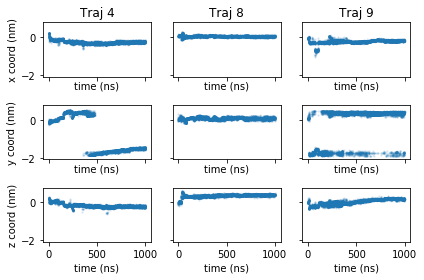

In [5]:
fig, axes = plt.subplots(3,3, sharex=True, sharey=True)
coords = ['x','y', 'z']
traj_nums = np.unique(df.traj)
for j in range(traj_nums.shape[0]):
    traj = df.loc[df['traj']==traj_nums[j], 'x':'z'].values
    t = df.loc[df['traj']==traj_nums[j], 't_ns'].values

    for i, ax in enumerate(axes[:,j]): 
        ax.scatter(t, traj[:,i], alpha=0.1, s=2)
        ax.set_xlabel('time (ns)')
        if i==0:
            ax.set_title('Traj {}'.format(traj_nums[j]))
        if j==0:
            ax.set_ylabel('{} coord (nm)'.format(coords[i]))

plt.tight_layout()

## Trajectory 4

In [6]:
traj = df.loc[df['traj']==traj_nums[0], 'x':'z'].values
dt = 0.1 # 0.1 ns timestep
tica_lag = 20 # lag in ns
tica_obj = coor.tica(traj, lag=int(tica_lag/dt), var_cutoff=0.9, kinetic_map=True)
print('TICA dimension ', tica_obj.dimension())
Y = tica_obj.get_output() # get tica coordinates


n_clusters = int(np.sqrt(traj.shape[0]))
clustering = coor.cluster_kmeans(Y,k=n_clusters, max_iter=100)


TICA dimension  2


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

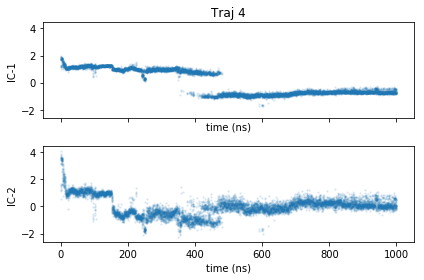

In [7]:
fig, axes = plt.subplots(Y[0].shape[1], sharex=True, sharey=True)
for i, ax in enumerate(axes): 
    ax.scatter(t, Y[0][:,i], alpha=0.1, s=2)
    ax.set_xlabel('time (ns)')
    if i==0:
        ax.set_title('Traj {}'.format(4))
    ax.set_ylabel('IC-{}'.format(i+1))

plt.tight_layout()

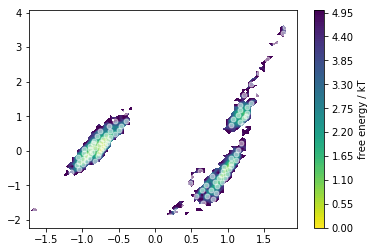

In [8]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r')
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='white', alpha=0.5,)

In [9]:
dtrajs = clustering.dtrajs
its = msm.timescales_msm(dtrajs, lags=1000, nits=10, errors='bayes', n_jobs=-1)


HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2'), max=17), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

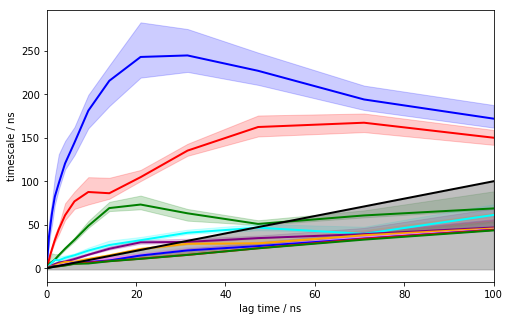

In [10]:
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=False, dt=dt, units='ns', linewidth=2)


In [11]:
msm_lag = 30
M = msm.bayesian_markov_model(dtrajs, int(msm_lag/dt))


HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

In [12]:
hmm = M.coarse_grain(2)
hmm.transition_matrix

array([[ 0.93483625,  0.06516375],
       [ 0.        ,  1.        ]])

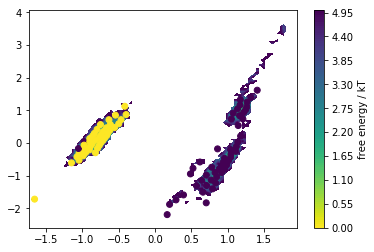

In [13]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r')

cc_x = clustering.clustercenters[hmm.observable_set,0]
cc_y = clustering.clustercenters[hmm.observable_set,1]
plt.scatter(cc_x,cc_y,c=hmm.metastable_assignments)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2'), max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

(<matplotlib.figure.Figure at 0x11b43a668>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119d2c748>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x119666048>]], dtype=object))

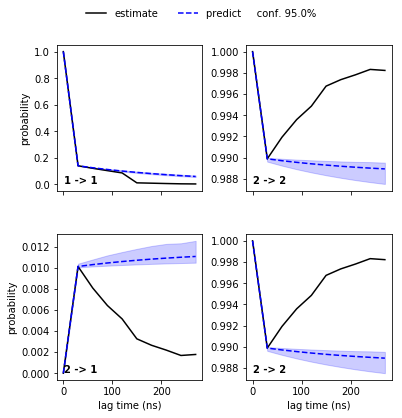

In [14]:
ck = M.cktest(2, err_est=False)

mplt.plot_cktest(ck, diag=True, layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3, dt=0.1, units='ns')


HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2'), max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

(<matplotlib.figure.Figure at 0x119644a90>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11963df60>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x1a2aea0978>]], dtype=object))

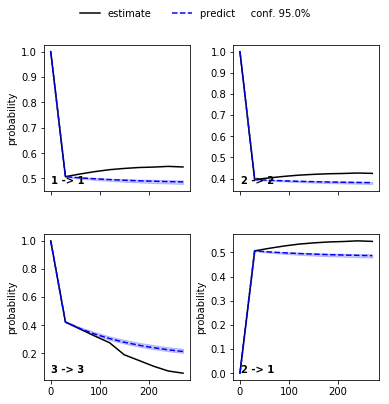

In [15]:
ck = M.cktest(3, err_est=False)

mplt.plot_cktest(ck, diag=True, layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3, dt=0.1, units='ns')

## Trajectory 8

In [16]:
traj = df.loc[df['traj']==traj_nums[1], 'x':'z'].values
dt = 0.1 # 0.1 ns timestep
tica_lag = 20 # lag in ns
tica_obj = coor.tica(traj, lag=int(tica_lag/dt), var_cutoff=0.95, kinetic_map=True)
print('TICA dimension ', tica_obj.dimension())
Y = tica_obj.get_output() # get tica coordinates


n_clusters = int(np.sqrt(traj.shape[0]))
clustering = coor.cluster_kmeans(Y,k=n_clusters, max_iter=100)


TICA dimension  2


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

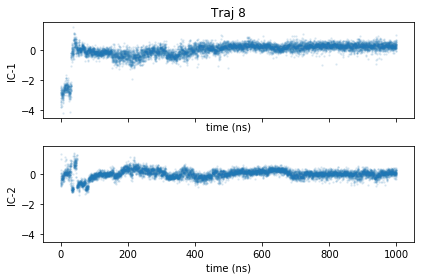

In [17]:
fig, axes = plt.subplots(Y[0].shape[1], sharex=True, sharey=True)
for i, ax in enumerate(axes): 
    ax.scatter(t, Y[0][:,i], alpha=0.1, s=2)
    ax.set_xlabel('time (ns)')
    if i==0:
        ax.set_title('Traj {}'.format(8))
    ax.set_ylabel('IC-{}'.format(i+1))

plt.tight_layout()

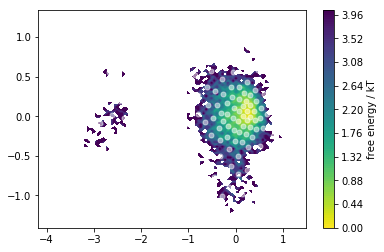

In [18]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r')
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='white', alpha=0.5,)

In [19]:
dtrajs = clustering.dtrajs
its = msm.timescales_msm(dtrajs, lags=1000, nits=10, errors='bayes', n_jobs=-1)


HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2'), max=17), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

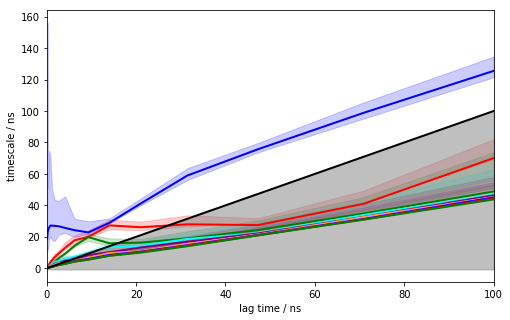

In [20]:
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=False, dt=dt, units='ns', linewidth=2)


In [21]:
msm_lag = 5
M = msm.bayesian_markov_model(dtrajs, int(msm_lag/dt))


HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

In [22]:
hmm = M.coarse_grain(2)
hmm.transition_matrix

array([[  9.42263901e-01,   5.77360992e-02],
       [  1.10455222e-04,   9.99889545e-01]])

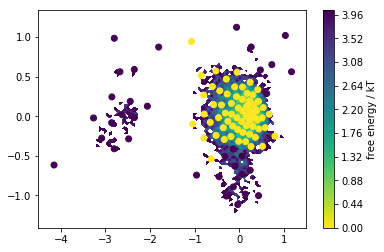

In [23]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r')

cc_x = clustering.clustercenters[hmm.observable_set,0]
cc_y = clustering.clustercenters[hmm.observable_set,1]
plt.scatter(cc_x,cc_y,c=hmm.metastable_assignments)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2'), max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

(<matplotlib.figure.Figure at 0x11a8c0780>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a365fb390>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x1a2ae54b70>]], dtype=object))

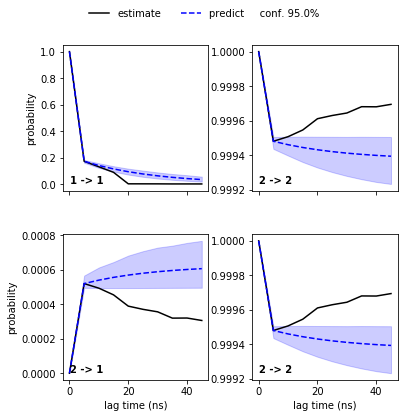

In [24]:
ck = M.cktest(2, err_est=False)

mplt.plot_cktest(ck, diag=True, layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3, dt=0.1, units='ns')


## Trajectory 9

In [25]:
traj = df.loc[df['traj']==traj_nums[2], 'x':'z'].values
dt = 0.1 # 0.1 ns timestep
tica_lag = 20 # lag in ns
tica_obj = coor.tica(traj, lag=int(tica_lag/dt), var_cutoff=0.95, kinetic_map=True)
print('TICA dimension ', tica_obj.dimension())
Y = tica_obj.get_output() # get tica coordinates


n_clusters = int(np.sqrt(traj.shape[0]))
clustering = coor.cluster_kmeans(Y,k=n_clusters, max_iter=100)


TICA dimension  2


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

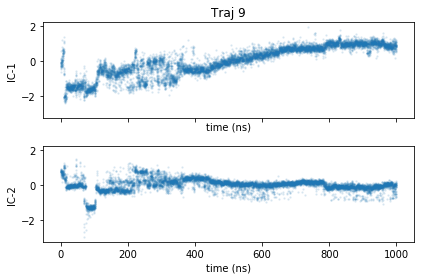

In [26]:
fig, axes = plt.subplots(Y[0].shape[1], sharex=True, sharey=True)
for i, ax in enumerate(axes): 
    ax.scatter(t, Y[0][:,i], alpha=0.1, s=2)
    ax.set_xlabel('time (ns)')
    if i==0:
        ax.set_title('Traj {}'.format(9))
    ax.set_ylabel('IC-{}'.format(i+1))

plt.tight_layout()

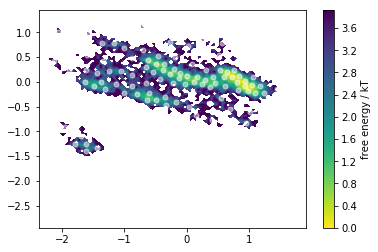

In [27]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r')
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='white', alpha=0.5,)

In [28]:
dtrajs = clustering.dtrajs
its = msm.timescales_msm(dtrajs, lags=1000, nits=10, errors='bayes', n_jobs=-1)


HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2'), max=17), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

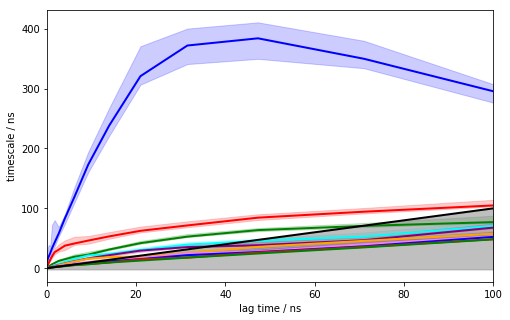

In [29]:
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=False, dt=dt, units='ns', linewidth=2)


In [30]:
msm_lag = 40
M = msm.bayesian_markov_model(dtrajs, int(msm_lag/dt))


HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

In [31]:
hmm = M.coarse_grain(2)
hmm.transition_matrix

array([[ 0.92672998,  0.07327002],
       [ 0.        ,  1.        ]])

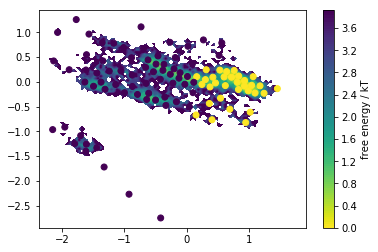

In [32]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap='viridis_r')

cc_x = clustering.clustercenters[hmm.observable_set,0]
cc_y = clustering.clustercenters[hmm.observable_set,1]
plt.scatter(cc_x,cc_y,c=hmm.metastable_assignments)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2'), max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

(<matplotlib.figure.Figure at 0x1a2895cf60>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1197a4d68>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x11a5b8ba8>]], dtype=object))

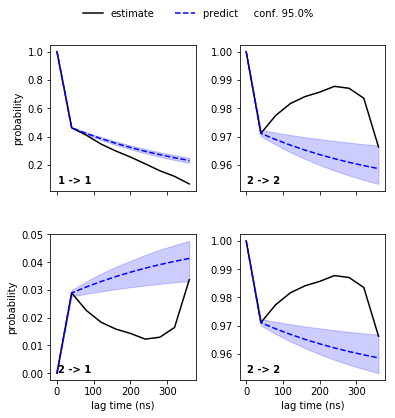

In [33]:
ck = M.cktest(2, err_est=False)

mplt.plot_cktest(ck, diag=True, layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3, dt=0.1, units='ns')


HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2'), max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

(<matplotlib.figure.Figure at 0x1a2895cc50>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2f0c7b70>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x1a2a3ab208>]], dtype=object))

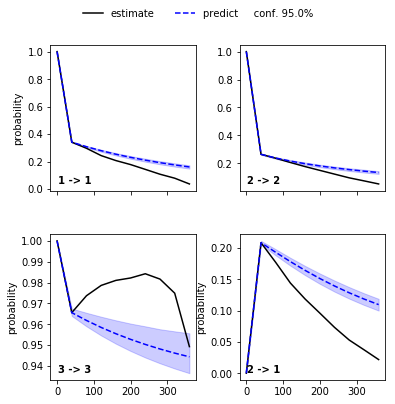

In [34]:
ck = M.cktest(3, err_est=False)

mplt.plot_cktest(ck, diag=True, layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3, dt=0.1, units='ns')